In [80]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from bs4 import BeautifulSoup
import urllib.request
import re
import requests
import pandas as pd
import datetime
import os
import glob


In [81]:

df = pd.DataFrame(columns=['ilosc_przejazdow', 'data_przejazdu'])

html_page = requests.get("https://www.wroclaw.pl/open-data/dataset/wrmprzejazdy_data/resource_history/c737af89-bcf7-4f7d-8bbc-4a0946d7006e").text
soup = BeautifulSoup(html_page, 'html.parser')
list = soup.find_all(class_='heading')
list = list[1:]
list.reverse()

In [82]:
date2022 = datetime.datetime(2022, 1, 1)

In [83]:

# list = list[:5] #test na malej ilosc elem
# quantity = []
for elem in list:

    name = elem.contents
    elem = str(elem)

    name = str(name)
    name = name.split("_")[2]

    date = datetime.datetime(int(name.split("-")[0]), int(name.split("-")[1]), int(name.split("-")[2]))
    if date>=date2022:
        link = elem.split(" ")
        link = link[2]
        link = link[5:]
        link = link[1:]
        link = link[:-1]
        # link = link.replace("\""," ")

        if os.path.exists(os.path.join("daily_csv", f"{name}.csv")):
            dailyDate = pd.read_csv(os.path.join("daily_csv", f"{name}.csv"))
            quantity = len(dailyDate)
            df = df.append({'ilosc_przejazdow':quantity,'data_przejazdu':name},ignore_index=True)
            continue

        dailyDate = pd.read_csv(link)
        dailyDate.to_csv(os.path.join("daily_csv", f"{name}.csv"))
        quantity = len(dailyDate)
        df = df.append({'ilosc_przejazdow':quantity,'data_przejazdu':name},ignore_index=True)



        # df["ilosc_przejazdow"]=c.__len__()
        # print(str(date) + " greater than "+ str(date2022))
    # else : print(str(date) + " less than "+ str(date2022))


# df["ilosc_przejazdow"]=quantity
df
# items = list.find_all('a')
# print(soup.prettify())
# for link in soup.findAll('a', attrs={'href': re.compile("^http://")}):
#     print(link.get('href'))

C:\Users\march\AppData\Local\Temp\ipykernel_18104\2380825751.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\march\AppData\Local\Temp\ipykernel_18104\2380825751.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\march\AppData\Local\Temp\ipykernel_18104\2380825751.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\march\AppData\Local\Temp\ipykernel_18104\2380825751.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\march\AppData\Local\Temp\ipykernel_18104\2380825751.py:23: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

,ilosc_przejazdow,data_przejazdu
0,1259,2022-1-1
1,1259,2022-1-2
2,1172,2022-1-3
3,2083,2022-1-4
4,2083,2022-1-4
...,...,...
156,11309,2022-6-3
157,11299,2022-6-4
158,11777,2022-6-5
159,8244,2022-6-6


In [84]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df["data_przejazdu"],
                         y=df["ilosc_przejazdow"],
                         mode='markers',
                         marker=dict(size=3, color="blue")))
fig.show()

In [85]:

all_files = glob.glob("root_csv"+"/*.csv")
archieved = pd.concat(map(pd.read_csv, all_files), ignore_index=True)
archieved = pd.DataFrame(archieved, columns=["UID wynajmu","Data zwrotu"])
archieved["Data zwrotu"] = pd.to_datetime(archieved["Data zwrotu"]).dt.date
archieved= archieved.groupby(archieved["Data zwrotu"]).count()
archieved = archieved.reset_index()

In [86]:
archieved["ilosc_przejazdow"] = archieved["UID wynajmu"]
archieved["data_przejazdu"] = archieved["Data zwrotu"]
# archieved.rename(columns={'UID wynajmu': 'przejazdy'})
archieved


,Data zwrotu,UID wynajmu,ilosc_przejazdow,data_przejazdu
0,2020-01-01,634,634,2020-01-01
1,2020-01-02,971,971,2020-01-02
2,2020-01-03,1017,1017,2020-01-03
3,2020-01-04,492,492,2020-01-04
4,2020-01-05,629,629,2020-01-05
...,...,...,...,...
665,2021-11-26,3663,3663,2021-11-26
666,2021-11-27,3158,3158,2021-11-27
667,2021-11-28,1191,1191,2021-11-28
668,2021-11-29,2707,2707,2021-11-29


In [87]:
all_time = pd.concat([archieved, df], ignore_index=True).drop(["Data zwrotu", "UID wynajmu"], axis=1)
all_time["data_przejazdu"] = pd.to_datetime(all_time["data_przejazdu"], format='%Y-%m-%d').dt.date
all_time.set_index("data_przejazdu", inplace=True)
all_time

,ilosc_przejazdow
data_przejazdu,
2020-01-01,634
2020-01-02,971
2020-01-03,1017
2020-01-04,492
2020-01-05,629
...,...
2022-06-03,11309
2022-06-04,11299
2022-06-05,11777


In [88]:
import meteostat
# from datetime import datetime, timedelta
# Przygotowanie obiektów dat
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime.now()

# Pobieranie danych nt. stacji
stations = meteostat.Stations()
wroclaw_req = stations.nearby(51, 17)
wroclaw = wroclaw_req.fetch(1)

# Pobieranie danych ze stacji day by day
weather_data_req = meteostat.Daily(wroclaw, start, end)
weather_data = weather_data_req.fetch()
weather_data = weather_data.reset_index()
weather_data = weather_data[["time", "tavg", "prcp"]]
weather_data["time"] = pd.to_datetime(weather_data["time"]).dt.date
weather_data.set_index("time", inplace=True)
weather_data


,tavg,prcp
time,,
2020-01-01,1.3,0.0
2020-01-02,-2.2,0.0
2020-01-03,1.1,0.0
2020-01-04,4.3,0.5
2020-01-05,0.3,1.0
...,...,...
2022-06-01,16.5,0.0
2022-06-02,15.2,0.3
2022-06-03,17.3,0.0


In [122]:
# merged = pd.concat([all_time, weather_data],  join="inner", axis=1)
merged = all_time.join(weather_data)
merged = merged.fillna(0)
merged


,ilosc_przejazdow,tavg,prcp
2020-01-01,634,1.3,0.0
2020-01-02,971,-2.2,0.0
2020-01-03,1017,1.1,0.0
2020-01-04,492,4.3,0.5
2020-01-05,629,0.3,1.0
...,...,...,...
2022-06-03,11309,17.3,0.0
2022-06-04,11299,19.7,3.5
2022-06-05,11777,19.1,0.0
2022-06-06,8244,0.0,0.0


In [123]:
merged["rolling_avg_7d"] = merged["ilosc_przejazdow"].rolling(7).mean()
merged = merged.fillna(0)
merged = merged.astype({'rolling_avg_7d':'int'})
# merged = merged.reset_index()
merged

,ilosc_przejazdow,tavg,prcp,rolling_avg_7d
2020-01-01,634,1.3,0.0,0
2020-01-02,971,-2.2,0.0,0
2020-01-03,1017,1.1,0.0,0
2020-01-04,492,4.3,0.5,0
2020-01-05,629,0.3,1.0,0
...,...,...,...,...
2022-06-03,11309,17.3,0.0,9026
2022-06-04,11299,19.7,3.5,9109
2022-06-05,11777,19.1,0.0,9838
2022-06-06,8244,0.0,0.0,10130


In [124]:
merged['prev_value'] = merged["ilosc_przejazdow"].shift(1)
merged = merged.fillna(0)
merged = merged.astype({'prev_value':'int'})
merged

,ilosc_przejazdow,tavg,prcp,rolling_avg_7d,prev_value
2020-01-01,634,1.3,0.0,0,0
2020-01-02,971,-2.2,0.0,0,634
2020-01-03,1017,1.1,0.0,0,971
2020-01-04,492,4.3,0.5,0,1017
2020-01-05,629,0.3,1.0,0,492
...,...,...,...,...,...
2022-06-03,11309,17.3,0.0,9026,11328
2022-06-04,11299,19.7,3.5,9109,11309
2022-06-05,11777,19.1,0.0,9838,11299
2022-06-06,8244,0.0,0.0,10130,11777


In [127]:
merged['months'] = pd.DatetimeIndex(merged.index).month
df = pd.DataFrame({'months': ['1', '2', '3','4','5','6','7','8','9','10','11','12']})

pd.get_dummies(df["months"],prefix='months',drop_first=True)

,months_10,months_11,months_12,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,1
9,1,0,0,0,0,0,0,0,0,0,0


In [128]:
merged = pd.concat([merged,pd.get_dummies(merged['months'], prefix='months')],axis=1)
merged

,ilosc_przejazdow,tavg,prcp,rolling_avg_7d,prev_value,months,months_1,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9,months_10,months_11,months_12
2020-01-01,634,1.3,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-02,971,-2.2,0.0,0,634,1,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-03,1017,1.1,0.0,0,971,1,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-04,492,4.3,0.5,0,1017,1,1,0,0,0,0,0,0,0,0,0,0,0
2020-01-05,629,0.3,1.0,0,492,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03,11309,17.3,0.0,9026,11328,6,0,0,0,0,0,1,0,0,0,0,0,0
2022-06-04,11299,19.7,3.5,9109,11309,6,0,0,0,0,0,1,0,0,0,0,0,0
2022-06-05,11777,19.1,0.0,9838,11299,6,0,0,0,0,0,1,0,0,0,0,0,0
2022-06-06,8244,0.0,0.0,10130,11777,6,0,0,0,0,0,1,0,0,0,0,0,0


In [131]:
X = merged.drop(["ilosc_przejazdow"], axis=1)
Y = merged["ilosc_przejazdow"]

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [136]:
# X_train = X_train.reshape(-1, 1)
# X_test = X_test.reshape(-1, 1)
# Y_train.ravel()
X_train

,tavg,prcp,rolling_avg_7d,prev_value,months,months_1,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9,months_10,months_11,months_12
2021-05-22,14.0,0.0,7875,7919,5,0,0,0,0,1,0,0,0,0,0,0,0
2021-01-11,-1.8,0.0,926,685,1,1,0,0,0,0,0,0,0,0,0,0,0
2021-05-07,7.6,0.0,4291,5326,5,0,0,0,0,1,0,0,0,0,0,0,0
2022-01-01,11.1,0.0,2787,2722,1,1,0,0,0,0,0,0,0,0,0,0,0
2020-11-28,2.6,0.8,2412,2170,11,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-12,11.2,0.3,3251,3739,3,0,0,1,0,0,0,0,0,0,0,0,0
2020-05-16,10.7,0.0,2770,3227,5,0,0,0,0,1,0,0,0,0,0,0,0
2020-10-27,9.2,0.0,4763,5712,10,0,0,0,0,0,0,0,0,0,1,0,0
2021-04-10,8.1,0.0,2878,4190,4,0,0,0,1,0,0,0,0,0,0,0,0


In [138]:
from scipy.optimize import curve_fit

def func(x, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q):
    return a*x["tavg"] + b+x["prcp"] + c*x["rolling_avg_7d"] + d*x["prev_value"] + e*x["months_1"] + f*x["months_2"] + g*x["months_3"] + h*x["months_4"] + i*x["months_5"] + j*x["months_6"] + k*x["months_7"] + l*x["months_8"]+ m*x["months_9"] + n*x["months_10"] + o*x["months_11"] + p*x["months_12"] + q

params, _ = curve_fit(func, xdata=X_train, ydata=Y_train)
params

array([ 1.05281364e+02,  3.47778963e+05,  5.96020177e-01,  2.74701786e-01,
        3.37118489e+05,  3.37050432e+05,  3.37235073e+05,  3.36851603e+05,
        3.36780703e+05,  3.36461434e+05,  3.36168854e+05,  3.35957456e+05,
        3.36575428e+05,  3.36637553e+05,  3.36854657e+05,  3.36972606e+05,
       -6.84917365e+05])

In [140]:
class CustomModelWrapper:
    def __init__(self, pred_fun, params):
        self.pred_fun = pred_fun
        self.params = params

    def predict(self, x):
        return self.pred_fun(x.ravel(), *params)

In [141]:
model_custom = CustomModelWrapper(func, params)

In [146]:
X_axis = np.linspace(start=X.index.min(), stop=X.index.max(), num=np.floor(X.index.max()-X.index.min()).astype(np.datetime_data()))
# print(np.floor(X.max()-X.min()).astype(np.uint32))
X_axis

TypeError: must be real number, not datetime.timedelta

<AxesSubplot:ylabel='ilosc_przejazdow'>

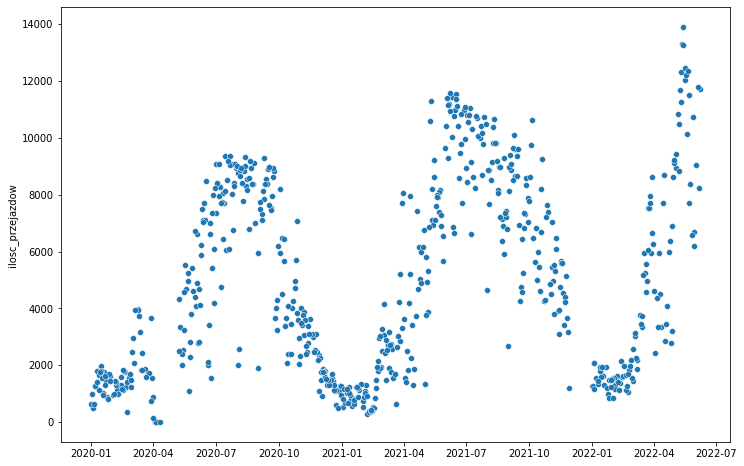

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(12, 8)
sns.scatterplot(x=X_train.index, y=Y_train)
# sns.lineplot(x=X_axis, y=model_custom.predict(X_axis_reshaped), color="orange")

In [118]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=merged.index,
                         y=merged["ilosc_przejazdow"],
                         mode='markers',
                         marker=dict(size=3, color="blue")
                         ))
fig.show()